Let's try to plot the phase portrait and bifurcation diagram of the E-I model.

Do this bit without the noise

In [1]:
# let's get what we need together
from __future__ import division
import PyDSTool as dst
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas
import scipy.io as si
import brian2

/Users/seanfw/miniconda2/lib/python2.7/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)


PyDSTool_ExistError: 'null_curve_y failed: points were out of domain'

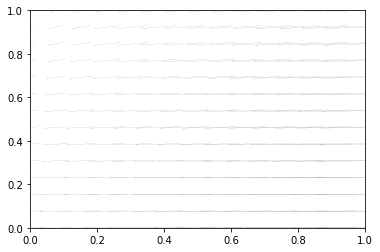

In [13]:
# we must give a name
DSargs = dst.args(name='E-I_model')

# parameters
DSargs.pars = { 'tau_NMDA': 0.06,
                'tau_GABA': 0.005,
                'a_E': 270.,
                'b_E': 108.,
                'd_E': 0.154,
                'a_I': 615,
                'b_I': 177,
                'd_I': 0.087,
                'gam': 0.641,
                'g_Eself': 0.52,
                'g_IE':   0.25,
                'g_EI': - 0.35,
                'g_Iself': - 0.2,
                'I_0': 0.31,
                'I_ext': 0}

DSargs.pars = { # Time constants
                'tau_NMDA': 0.06   * brian2.second,    # s 
                'tau_AMPA': 0.002   * brian2.second,    # s 
                'tau_GABA': 0.005  * brian2.second,    # s 
                'tau_rates': 0.002 * brian2.second,    # s 

                # f-I curve parameters - E populations
                'a_E': 270.,   # Hz/nA
                'b_E': 108.,   # Hz
                'd_E': 0.154,  # s
                'gam': 0.641,  # unitless

                # f-I curve parameters - I populations
                'c_I': 330,    # Hz/nA
                'r0_I': -95,   # Hz

                # Strength of connections from E cells
                'g_E_self': 0.4 ,        # nA - from E to E
                'g_IE':     0.23,        # nA - from E to I

                # Strength of connections from I cells
                'g_I_self': -0.15,     # nA  - from I to I
                'g_EI':     -0.3,     # nA  - from I to E

                # Background inputs
                'I0_E': 0.31     * brian2.nA,           # nA - background onto E population
                'I0_I': 0.22      * brian2.nA,         # nA - background onto I population

#                 # Noise std dev
#                 'std_noise': 0.01 * brian2.nA,         # nA  - standard deviation of noise input  

#                 # initial values
#                 'r0_E': 5 * brian2.Hz,

#                 # stimulus strength
                 'I_ext': 0 
                    }

# auxiliary functions: fI curve and recurrent current
DSargs.fnspecs  = {
    'fI_E': (['I'], '(a_E*I-b_E)/(1.0 - exp(-d_E*(a_E*I-b_E)))'),
    'fI_I': (['I'], 'c_I*I + r0_I'),
    'recCurrE': (['x', 'y'], 'g_E_self*x + g_EI*y + I0_E'),
    'recCurrI': (['x', 'y'], 'g_I_self*x + g_IE*y + I0_I')
}

# rhs of the differential equations
DSargs.varspecs = {'S_NMDA': '(-S_NMDA/tau_NMDA + gam*(1.0 - S_NMDA)*fI_E(recCurrE(S_NMDA,S_GABA) + I_ext))',
                   'S_GABA': ' -S_GABA/tau_GABA + fI_I(recCurrI(S_GABA,S_NMDA))'}

# initial conditions
DSargs.ics = {'S_NMDA': 0.1, 'S_GABA': 0.1}

# set the range of integration
DSargs.tdomain = [0,10]

# variable domain for the phase plane analysis
DSargs.xdomain = {'S_GABA': [0,1], 'S_NMDA': [0,1]}

# variable domain for the phase plane analysis
DSargs.pdomain = {'I_ext': [0,0.3] }

# Create the model object
dmModel = dst.Vode_ODEsystem(DSargs)

# Open a figure and plot the vector field
from PyDSTool.Toolbox import phaseplane as pp

pp.plot_PP_vf(dmModel,'S_GABA','S_NMDA',N=14, scale_exp=-1)

# Find the fixed points
fp_coord = pp.find_fixedpoints(dmModel,n=6,eps=1e-8)

# Find and plot the nullclines
nulls_x, nulls_y = pp.find_nullclines(dmModel, 'S_NMDA', 'S_GABA', n=3, eps=1e-8,max_step=0.01,fps=fp_coord)

plt.plot(nulls_x[:,1], nulls_x[:,0],'b')
plt.plot(nulls_y[:,1], nulls_y[:,0],'g')

# Compute the jacobian to determine the stability of the fixed points
jac, new_fnspecs = \
dst.prepJacobian(dmModel.funcspec._initargs['varspecs'],
['S_GABA', 'S_NMDA'], dmModel.funcspec._initargs['fnspecs'])
scope = dst.copy(dmModel.pars)
scope.update(new_fnspecs)
jac_fn = dst.expr2fun(jac, ensure_args=['t'], **scope)

# add fixed points to the phase portrait

for i in range(0,len(fp_coord)):
    fp = pp.fixedpoint_2D(dmModel,dst.Point(fp_coord[i]),
                         jac = jac_fn, eps=1e-8)
    pp.plot_PP_fps(fp)
    
# compute an example trajectory
traj = dmModel.compute('trajectory1')
pts = traj.sample()
plt.plot(pts['S_GABA'],pts['S_NMDA'],'r-o')

Now let's sketch the bifurcation diagram

WARNING    /Users/seanfw/miniconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
 [py.warnings]


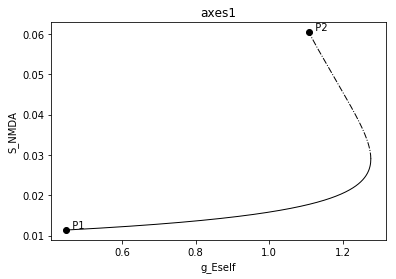

In [3]:
# Set the lower bound of the control (bifurcation) parameter
dmModel.set(pars = {'g_Eself': 0.45})

# initial conditions # Close to one of the steady states
dmModel.set(ics = {'S_NMDA': 0.01, 'S_GABA': 0.01})

# Set up continuation class
PC = dst.ContClass(dmModel)

# Equilibrium point curve (EP-C). The branch is labeled EQ1:
PCargs = dst.args(name='EQ1', type='EP-C')
PCargs.freepars = ['g_Eself'] # control parameter
PCargs.MaxNumPoints = 1000
PCargs.MaxStepSize  = 1e-4
PCargs.MinStepSize  = 1e-5
PCargs.StepSize     = 1e-3
PCargs.LocBifPoints = ['all'] #['LP','BP']   # detect limit and saddle-node bifurcation types
PCargs.SaveEigen = True # to determine the stability of branches

PC.newCurve(PCargs)

PC['EQ1'].forward()

PC['EQ1'].display(['g_Eself','S_NMDA'], stability=True, figure=1)